In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dLux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
# import pickle as p
import equinox as eqx
import optax
import functools as ft # used for filtering
from tqdm.notebook import tqdm

In [3]:
from jax.scipy.stats import poisson # For loss fucntion

In [4]:
from dLux.base import *
from dLux.layers import *
from dLux.propagators import *

In [5]:
def get_mask(size, wavel):
    from scipy.ndimage import map_coordinates
    mask_in = phase2opd(opd2phase(np.load('test_mask.npy'), 4.5e-07), wavel)
    xs = np.linspace(0, mask_in.shape[0], size)
    coords = np.array(np.meshgrid(xs, xs))
    mask = np.array(map_coordinates(mask_in, coords, order=0))
    return mask

def nyquist_pix_airy(Nyq_rate, wavel, optic_size, focal_length):
    """ Assumes Airy disk """
    airy_fringe = focal_length * 1.22*wavel / optic_size
    det_pixelsize = 1/Nyq_rate * 0.5 * airy_fringe
    return det_pixelsize

def rand(shape):
    return np.array(onp.random.rand(np.prod(np.array(shape))).reshape(shape))

def norm(mean, deviation, shape):
    return np.array(onp.random.normal(mean, deviation, shape))

def opd2phase(opd, wavel):
    return 2*np.pi*opd/wavel

def phase2opd(phase, wavel):
    return phase*wavel/(2*np.pi)

def rad2arcsec(values):
    return values * 3600 * 180 / np.pi

def arcsec2rad(values):
    return values * np.pi / (3600 * 180)

In [6]:
plt.figure() # this need to be run to make this work properly
plt.show()
plt.rcParams['figure.dpi'] = 120
plt.rcParams['image.cmap'] = 'hot'
plt.rcParams["text.usetex"] = 'true'

<Figure size 432x288 with 0 Axes>

In [7]:
onp.random.seed(0)

---

# The Scene object!

The Scene object is the primary object of dLux, so here is a quick overview.

> dLux curently does not check that inputs are correctly shaped/formatted in order to making things work appropriately (under development)

## Inputs:


### layers: list, required
 - A list of layers that defines the tranformaitons and operations of the system (typically optical)
 
### wavels: ndarray, optional
 - An array of wavelengths in meters to simulate
 - The shape must be 1d - stellar spectrums are controlled through the weights parameter
 - No default value is set if not provided and this will throw an error if you try to call functions that depend on this parameter
 - It is left as optional so that functions that allow wavelength input can be called on objects without having to pre-input wavelengths
 
### positions: ndarray, optional
 - An array of (x,y) stellar positions in units of radians, measured as deivation of the optical axis. 
 - Its input shape should be (Nstars, 2), defining an x, y position for each star. 
 - If not provided, the value defaults to (0, 0) - on axis

### fluxes: ndarray, optional
 - An array of stellar fluxes, its length must match the positions inputs size to work properly
 - Theoretically this has arbitrary units, but we think of it as photons
 - Defaults to 1 (ie, returning a unitary flux psf if not specified)

### weights: ndarray, optional
 - An array of stellar spectral weights (arb units)
 - This can take multiple shapes
     - Default is to weight all wavelengths equally (top-hat)
     - If a 1d array is provided this is applied to all stars, shape (Nwavels)
     - if a 2d array is provided each is applied to each individual star, shape (Nstars, Nwavels)
 - Note the inputs values are always normalised and will not directly change total output flux (inderectly it can change it by weighting more flux to wavelengths with more aperture losses, for example)

### dithers: ndarray, optional
 - An arary of (x, y) positional dithers in units of radians
 - Its input shape should be (Nims, 2), defining the (x,y) dither for each image
 - if not provided, defualts to no-dither

### detector_layers: list, optional
 - A second list of layer objects designed to allow processing of psfs, rather than wavefronts
 - It is applied to each image after psfs have been approraitely weighted and summed
     
     
## Functions:

### __call__()
> Primary call function applying all parameters of the scene object through the systems
 - Takes no inputs, returning a image, or array of images
 - The primary function designed to apply all of the inputs of the class in order to generate the appropriate output images
 - Automatically maps the psf calcualtion over both wavelength and input position for highly efficient calculations
 - It takes no inputs as to allow for easier coherent optimsation of the whole system 
 
### propagate_mono(wavel):
> Propagates a single monochromatic wavelength through only the layers list
 - Inputs:
     - wavel (float): The wavelength in meters to be modelled through the system
     - offset (ndarray, optional): the (x,y) offest from the optical axis in radians
 - Returns: A sigle monochromatic PSF
 
### propagate_single(wavels)
> Propagataes a single broadband stellar source through the layers list
 - Inputs:
     - wavels (ndarray): The wavelengths in meters to be modelled through the system
     - offset (ndarray, optional): the (x,y) offest from the optical axis in radians
     - weights (ndarray, optional): the realative weights of each wavelength, 
         - No normalisation is applied to the weights to allow user flexibility
         - Unitary weights will output a total sum of 1
 - Returns: A single broadband PSF
 
 
### debug_prop(wavels)
> Propagataes a single wavelength through while storing the intermediary value of the wavefront and pixelscale between each operation. This is designed to help build and debug unexpected behaviour. It is functionally a mirror of propagate_mono() that stored intermediary values/arrays
 - Inputs:
     - wavels (ndarray): The wavelengths in meters to be modelled through the system
     - offset (ndarray, optional): the (x,y) offest from the optical axis in radians
 - Returns: [A single monochromatic PSF, intermediate wavefront, intermediate pixelscales]
     
     



---
---
---


# Complex optimisation schemes

This tutorial is designed to show how ∂Lux allows you to optimise more complex model where we want to learn multiple parameters. You should review the `single_param_example.ipynb` tutorial first if you haven't already. 

In this notebook we are going to generate a scene of multiple stars through a novel optical system utilising a diffractive pupil. From this we will recover the positions and fluxes of the stars, as well as the optical aberrations of the system. We will also show how to combine multiple optax optimsation algorithms and apply schedules to them in order to give a more complete picture of how ∂Lux, Equinox and Optax all interact with each other

---

We start by defining our optical system by its layers and observing the resultant PSF

In [8]:
# Basic Optical Parameters
aperture = 1.
fl = 10.     
wf_npix = 128 

# Spectral Params
min_wavel = 450e-9
max_wavel = 550e-9
wavels = np.linspace(min_wavel, max_wavel, 5)

# Mask/pupil parameters
mask = get_mask(wf_npix, np.mean(wavels))

# Zernike Parameters
indexes = np.arange(3, 10) # Ignore piston tip tilt
coefficients = 2e-8 * np.array(onp.random.normal(0, 0.5, len(indexes)))

# Detector Parameters
det_npix = 512 
det_pixsize = nyquist_pix_airy(4, np.mean(wavels), aperture, fl)

In [9]:
optical_layers = [
    TiltedWavefront    (wf_npix, aperture),                    # 1: Wavefront creation
    ApplyZernike       (wf_npix, coefficients, indexes=indexes), # 2: Apply Zernike Polynomials
    ApplyOPD           (wf_npix, mask),                          # Apply mask
    CircularAperture   (wf_npix),                                # 3: Apply ciruclar aperture
    NormaliseWavefront (wf_npix),
    MFT                (wf_npix, det_npix, 1, fl, det_pixsize),  # MFT
    Wavefront2PSF      (det_npix)]                               # 9: Calcualte PSF from wavefront

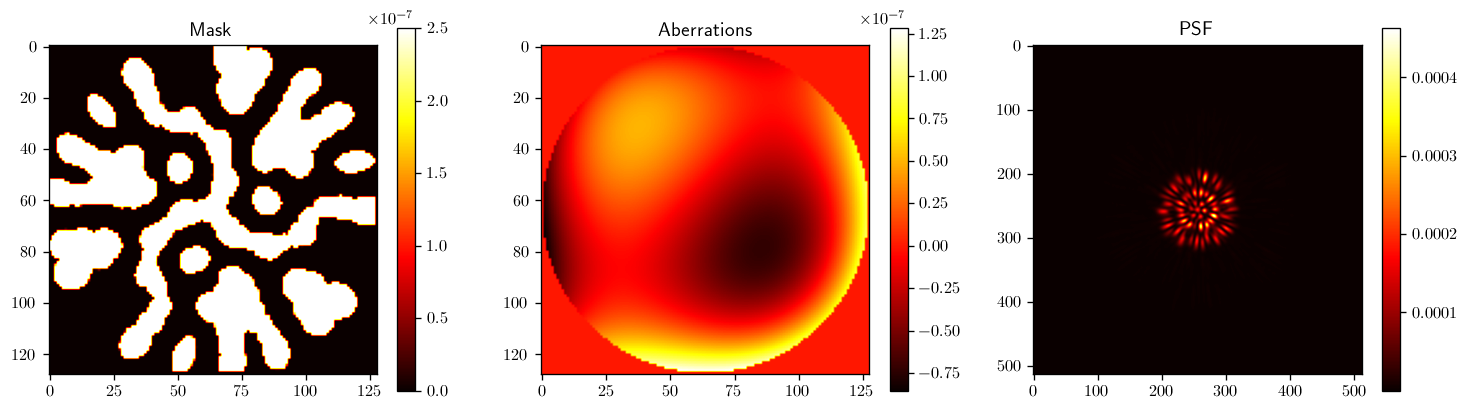

In [10]:
psf = Scene(optical_layers).propagate_single(wavels)
mask_in = optical_layers[2].array
aberr_in = optical_layers[1].get_total_opd()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Mask")
plt.imshow(mask_in)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Aberrations")
plt.imshow(aberr_in)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()
plt.show()

---

# Constructing the Astrophysical Scene

Now we need to define the positions and fluxes of the stars we wish to observe. In this tutorial we will generate them randomly.

Then we generate our data by applying poissonian noise to the output PSFs

In [11]:
Nstars = 10
positions = 1e-5*(2*rand([Nstars, 2]) - 1)
fluxes = 9e5*rand(Nstars) + 1e5

true_scene = Scene(
    layers=optical_layers, 
    wavels=wavels, 
    positions=positions, 
    fluxes=fluxes)

data = np.array(onp.random.poisson(true_scene()))

## Optimisable Parameters

Now we need to pertub our initial parameters and generate a model that we can optimise!

We will start by having no knowledge of the optical aberrations present and approximate knowledge of the positions and fluxes

In [12]:
layers_init = optical_layers
layers_init[1] = ApplyZernike(wf_npix, np.zeros(len(coefficients)), indexes=indexes)
positions_init = positions + 1e-6*norm(0, 0.2, [Nstars, 2])
fluxes_init = fluxes * norm(1, 0.2, [Nstars])

opt_model = Scene(
    layers=layers_init, 
    wavels=wavels, 
    positions=positions_init, 
    fluxes=fluxes_init)

psf_init = opt_model()

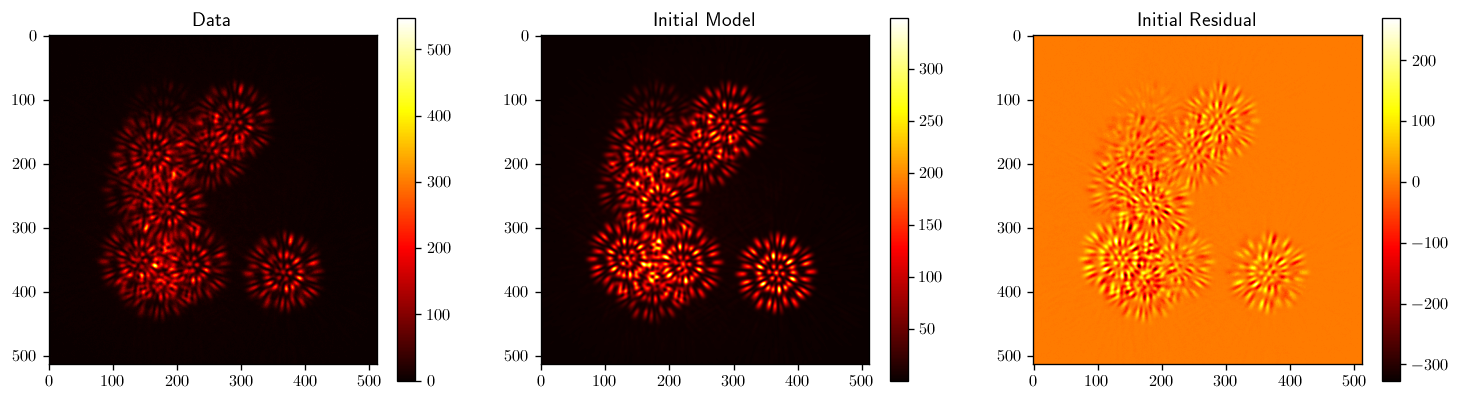

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Initial Model")
plt.imshow(psf_init)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Initial Residual")
plt.imshow(psf_init - data)
plt.colorbar()
plt.show()

---

## Optimisation

Now when we want to optimise multiple parameters using optax (as is likely) **we need to actually wrap our scene object in a list**. This is becuase of the way that Equinox and Optax interact. This can be mildy confusing but as long as we keep it in mind it is not a problem.

We first set up our `filter_spec` object, which tells Equinox which parameters we want to optimise. It operates like a binary mask except applied to arbitrary Equinox objects (such as our ∂Lux Scene objects). We initilise all parameters to `False` and then set the relevant parameters back to `True`, which is positions fluxes and zernike coefficients in our case. 

In [14]:
model_out = [opt_model]

# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, model_out)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda scene: scene[0].positions,              filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda scene: scene[0].fluxes,                 filter_spec, replace=True)
filter_spec = eqx.tree_at(lambda scene: scene[0].layers[1].coefficients, filter_spec, replace=True)

Now we define our loss function, which in this case is a poisson log-likelihood. We apply the jit decorator to get the code to compile, and pass the `filter_spec` parameter to the equinox filter_value_and_grad such that the functions returns gradients and losses, rather than just the loss. 

Remember the model object is wrapped in a list!!

In [15]:
@eqx.filter_jit
@ft.partial(eqx.filter_value_and_grad, filter_spec=filter_spec)
def loss_func(model, data):
    out = model[0]()
    return -np.sum(poisson.logpmf(data, out))

/Users/louis/mambaforge/envs/dLux/lib/python3.10/site-packages/equinox/grad.py:71: UserWarning: For brevity the `filter_spec` argument has been renamed `arg`
  warnings.warn("For brevity the `filter_spec` argument has been renamed `arg`")


In [16]:
%%time
initial_loss, initial_grads = loss_func(model_out, data) # Compile
print("Initial Loss: {}".format(int(initial_loss)))

Initial Loss: 1972155
CPU times: user 2.57 s, sys: 105 ms, total: 2.68 s
Wall time: 926 ms


## Optax optimisation Schemes

Now we need to set up our optax optimisation object, which is based on the `param_spec` object. This is similar to the `filter_spec` object but lets optax know which parameters to apply which learning algorithms/schedules. 

We initialise this object to have all parameters as part of the `'null'` class, these are the parameters that we don't want to optimise. We then set the parameters we care about in a very similar way to above, but set some string value instead that can be used to reference that parameter/set of parameters.

I won't go into detail about all of these optax objects here, you can read about the specifics in their documentation, but the basics scheme applied here is:
- Positional parameters: adam optimsier, 1e-8 learning rate
- Zernike parameters: adam optimsier, 1e-9 learning rate, applied after 25 epochs
- Flux parameters: adam optimsier, 1e4 learning rate, applied after 50 epochs

The learning rates are turned on in stages here not out of nessecity, but to show the correct syntax needed to nest optax schedules within this framework which should give users the ability to apply any desired optax optimisation scheme at any level of complexity

There Parameters are combined using the `optax.multi_trasform` along with the `param_spec` object we constructed. 

The final `opt_state` object is created using the syntax below, this should be able to kept fixed for all models

In [17]:
param_spec =  jax.tree_map(lambda _: "null", model_out)

# Set parameter groups
param_spec = eqx.tree_at(lambda scene: scene[0].positions,              param_spec, replace='positions')
param_spec = eqx.tree_at(lambda scene: scene[0].fluxes,                 param_spec, replace='fluxes')
param_spec = eqx.tree_at(lambda scene: scene[0].layers[1].coefficients, param_spec, replace='coeffs')

lr_pos =  1e-8
lr_zern, start_zern = 1e-9, 25
lr_flux, start_flux = 1e4, 50

zern_sched = optax.piecewise_constant_schedule(init_value=1e-12 * lr_zern, boundaries_and_scales={start_zern: int(1e12)})
flux_sched = optax.piecewise_constant_schedule(init_value=1e-12 * lr_flux, boundaries_and_scales={start_flux: int(1e12)})

optim = optax.multi_transform(
    {"null":        optax.adam(0.0), 
     "positions":   optax.adam(lr_pos),
     "fluxes":      optax.adam(flux_sched),
     "coeffs":      optax.adam(zern_sched)},
    param_spec)

opt_state = optim.init(eqx.filter(model_out, eqx.is_array_like))

Now we can optimise our models just as before!

In [18]:
errors, grads_out, models_out = [], [], []

model_out = [opt_model] # Re-initialise Model
for i in tqdm(range(150)):
    loss, grads = loss_func(model_out, data)    

    updates, opt_state = optim.update(grads, opt_state)
    model_out = eqx.apply_updates(model_out, updates)
    errors.append(loss)
    grads_out.append(grads)
    models_out.append(model_out)
    
    if i%25 == 0:
        print("{:.4f}  \t{:.0f}".format(np.log10(loss), loss))
    
psf_out = model_out[0]()
errors = np.array(errors)

  0%|          | 0/150 [00:00<?, ?it/s]

6.2949  	1972155
6.0135  	1031639
5.8011  	632506
5.7729  	592770
5.7705  	589572
5.7703  	589303


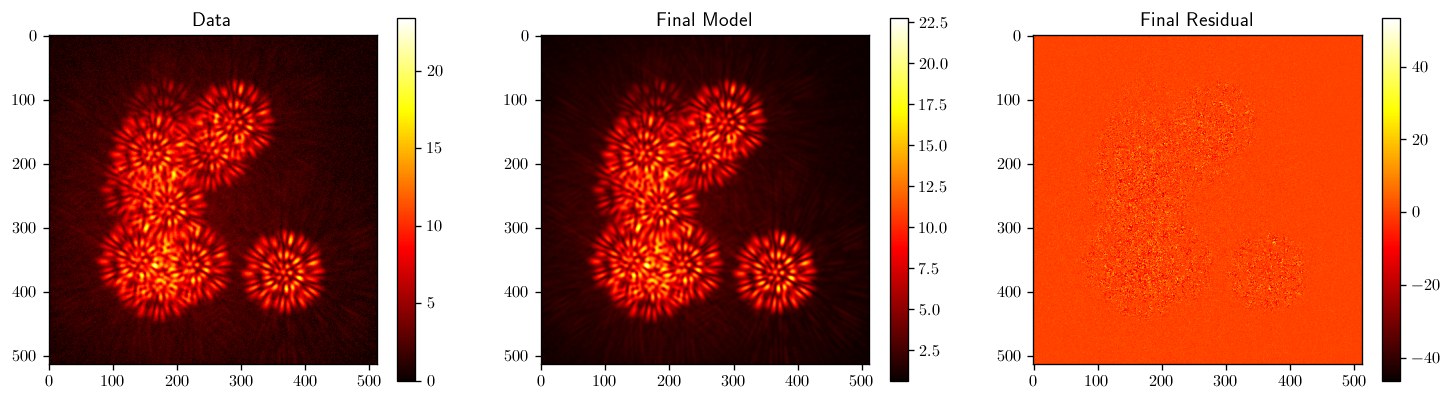

In [19]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Final Model")
plt.imshow(psf_out**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Final Residual")
plt.imshow(data - psf_out)
plt.colorbar()
plt.show()

In [20]:
# Extract Parameters at each epoch
positions_found = np.array([models_out[i][0].positions               for i in range(len(models_out))])
fluxes_found =    np.array([models_out[i][0].fluxes                  for i in range(len(models_out))])
coeffs_found =    np.array([models_out[i][0].layers[1].coefficients  for i in range(len(models_out))])

In [21]:
coeff_residuls = coefficients - coeffs_found
flux_residuls = fluxes - fluxes_found

positions_residuls = positions - positions_found
r_residual_rads = np.hypot(positions_residuls[:, :, 0], positions_residuls[:, :, 1])
r_residual = rad2arcsec(r_residual_rads)

nepochs = len(models_out)

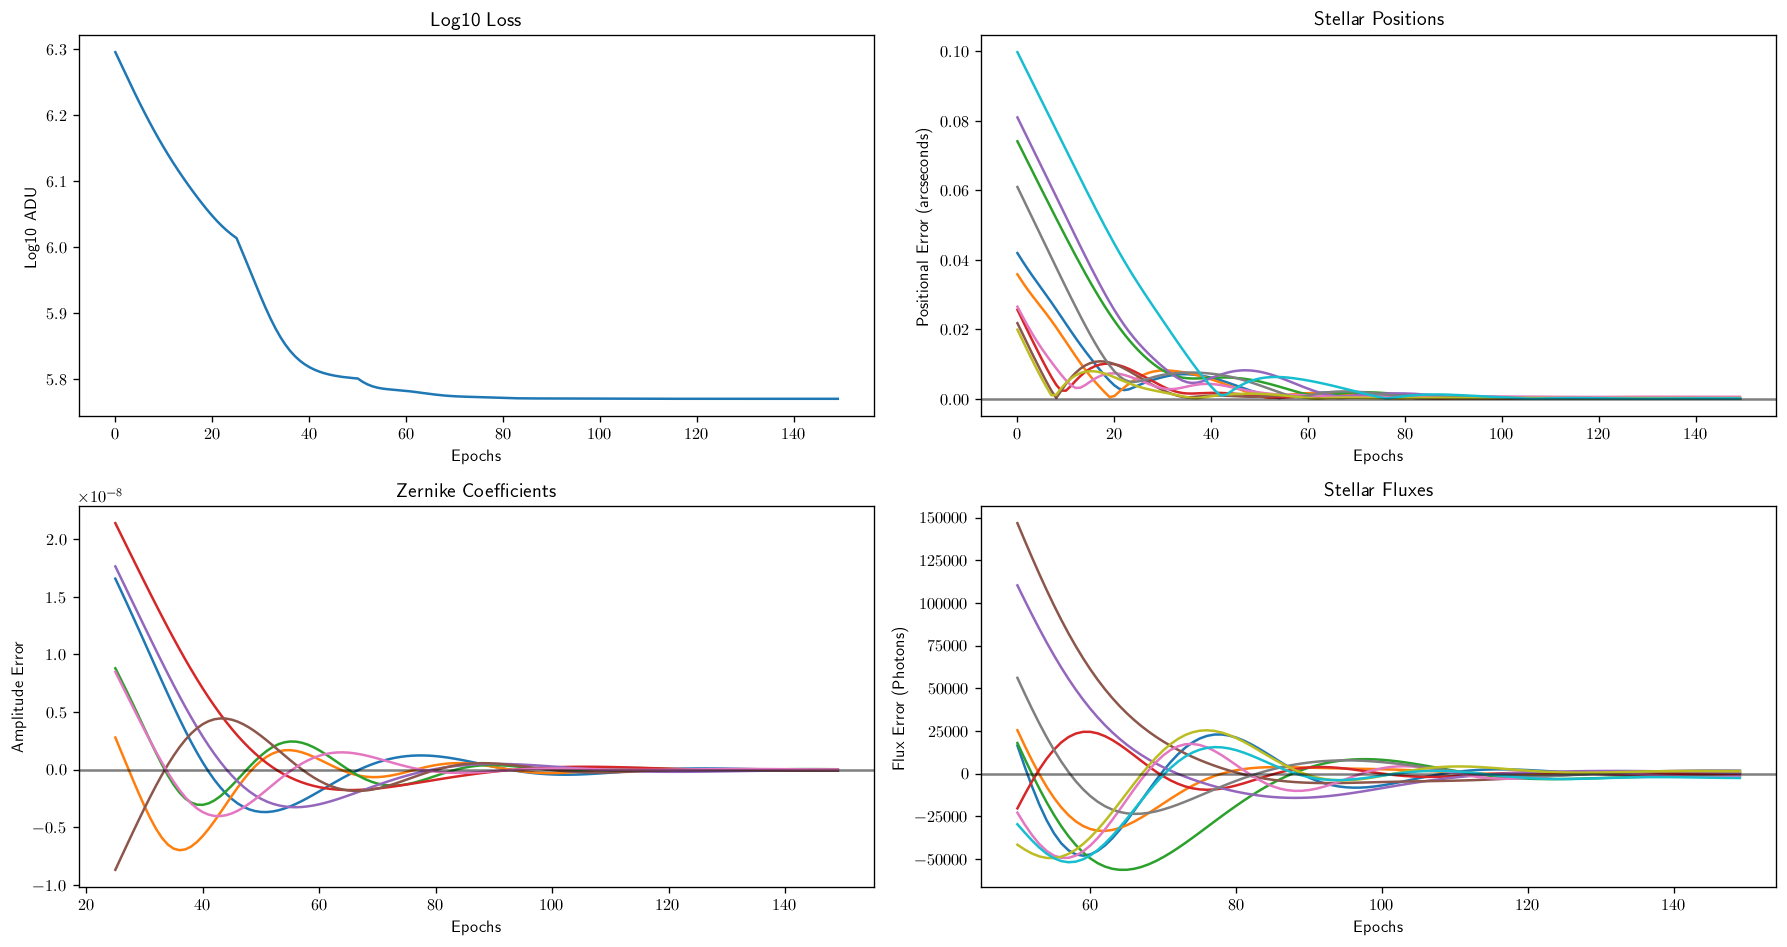

In [22]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.title("Log10 Loss")
plt.xlabel("Epochs")
plt.ylabel("Log10 ADU")
plt.plot(np.log10(errors))

plt.subplot(2, 2, 2)
plt.title("Stellar Positions")
plt.xlabel("Epochs")
plt.ylabel("Positional Error (arcseconds)")
plt.plot(r_residual)
plt.axhline(0, c='k', alpha=0.5)

m = start_zern
plt.subplot(2, 2, 3)
plt.title("Zernike Coefficients")
plt.xlabel("Epochs")
plt.ylabel("Amplitude Error")
plt.plot(np.arange(m, nepochs), coeff_residuls[m:])
plt.axhline(0, c='k', alpha=0.5)

m = start_flux
plt.subplot(2, 2, 4)
plt.title("Stellar Fluxes")
plt.xlabel("Epochs")
plt.ylabel("Flux Error (Photons)")
plt.plot(np.arange(m, nepochs), flux_residuls[m:])
plt.axhline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.show()